In [ ]:
import torch
import jovian
import torchvision
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torch.utils.data import DataLoader, TensorDataset, random_split

In [ ]:
project_name='02-insurance-linear-regression' # will be used by jovian.commit

## Step 1: Download and explore the data

Let us begin by downloading the data. We'll use the `download_url` function from PyTorch to get the data as a CSV (comma-separated values) file. 

In [ ]:
DATASET_URL = "https://hub.jovian.ml/wp-content/uploads/2020/05/insurance.csv"
DATA_FILENAME = "insurance.csv"
download_url(DATASET_URL, '.')

To load the dataset into memory, we'll use the `read_csv` function from the `pandas` library. The data will be loaded as a Pandas dataframe. See this short tutorial to learn more: https://data36.com/pandas-tutorial-1-basics-reading-data-files-dataframes-data-selection/

In [ ]:
dataframe_raw = pd.read_csv(DATA_FILENAME)
dataframe_raw.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


We're going to do a slight customization of the data, so that you every participant receives a slightly different version of the dataset. Fill in your name below as a string (enter at least 5 characters)

In [ ]:
your_name = 'Syeeda Kudhsia Fatima' # at least 5 characters

The `customize_dataset` function will customize the dataset slightly using your name as a source of random numbers.

In [ ]:
def customize_dataset(dataframe_raw, rand_str):
    dataframe = dataframe_raw.copy(deep=True)
    # drop some rows
    dataframe = dataframe.sample(int(0.95*len(dataframe)), random_state=int(ord(rand_str[0])))
    # scale input
    dataframe.bmi = dataframe.bmi * ord(rand_str[1])/100.
    # scale target
    dataframe.charges = dataframe.charges * ord(rand_str[2])/100.
    # drop column
    if ord(rand_str[3]) % 2 == 1:
        dataframe = dataframe.drop(['region'], axis=1)
    return dataframe

In [ ]:
data = customize_dataset(dataframe_raw, your_name)
data.head()

,age,sex,bmi,children,smoker,charges
665,43,male,46.05260,2,yes,42986.034704
579,25,female,28.39265,0,no,3238.556263
84,37,female,42.10800,2,yes,40234.884190
244,63,female,33.56540,0,yes,29818.397256
1307,32,male,34.02520,4,yes,21687.203588


In [ ]:
data.shape

(1271, 6)

In [ ]:
data.columns.values

array(['age', 'sex', 'bmi', 'children', 'smoker', 'charges'], dtype=object)

In [ ]:
data.isna().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
charges     0
dtype: int64

In [ ]:
data.describe()

,age,bmi,children,charges
count,1271.000000,1271.000000,1271.000000,1271.000000
mean,39.322581,37.079084,1.103855,13518.891197
std,14.059260,7.346579,1.210938,12333.883008
min,18.000000,19.311600,0.000000,1133.092639
25%,27.000000,31.841150,0.000000,4794.165435
50%,40.000000,36.784000,1.000000,9505.115050
75%,51.000000,41.866000,2.000000,17009.074650
max,64.000000,64.287300,5.000000,64408.132290


In [ ]:
num_rows = len(data)
print(num_rows)

1271


In [ ]:
num_cols = len(data.columns)
print(num_cols)

6


In [ ]:
num_cols = data.shape[1]
num_cols

6

In [ ]:
#input_cols = data.columns.values
#input_cols

In [ ]:
input_cols = [i for i in data.columns[:-1]]
input_cols

['age', 'sex', 'bmi', 'children', 'smoker']

In [ ]:
categorical_cols = data.loc[:,data.dtypes==np.object]
categorical_cols.head()


,sex,smoker
665,male,yes
579,female,no
84,female,yes
244,female,yes
1307,male,yes


In [ ]:
# we only have to give column names
columns = data.columns
numeric_cols = data._get_numeric_data().columns
print(numeric_cols)
categorical_cols = list(set(columns)-set(numeric_cols))
categorical_cols

Index(['age', 'bmi', 'children', 'charges'], dtype='object')


['smoker', 'sex']

In [ ]:
input_cols = data.iloc[:,:-1]
list(input_cols.columns.values)

['age', 'sex', 'bmi', 'children', 'smoker']

In [ ]:
#output_cols = data.iloc[:,-1]
#display(output_cols)

In [ ]:
output_cols = [data.columns[-1]]
output_cols

['charges']

In [ ]:
min_val = min(output_cols)
print('minimum:',min_val)

minimum: 1133.092639


In [ ]:
max_val = max(output_cols)
print('maximum:',max_val)

maximum: 64408.1322901


In [ ]:
average = output_cols.mean()
print('average: ',average)

average:  13518.891197422412


In [ ]:
print('min val is: ',output_cols.min() )
print('max val is: ',output_cols.max() )
print('avg val is: ',output_cols.mean() )

min val is:  1133.092639
max val is:  64408.1322901
avg val is:  13518.891197422412


In [ ]:
data.head()

,age,sex,bmi,children,smoker,charges
665,43,male,46.05260,2,yes,42986.034704
579,25,female,28.39265,0,no,3238.556263
84,37,female,42.10800,2,yes,40234.884190
244,63,female,33.56540,0,yes,29818.397256
1307,32,male,34.02520,4,yes,21687.203588


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


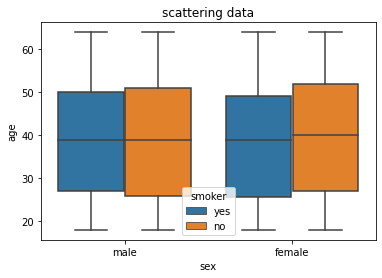

In [ ]:
# Create a scatter plot
import seaborn as sns
sns.boxplot(data.sex, data.age, hue=data.smoker);

# Chart title
plt.title("scattering data");
plt.show()

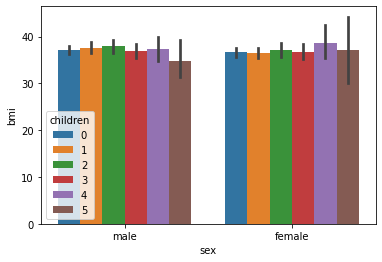

In [ ]:
sns.barplot(x="sex", y="bmi", hue="children", data=data);

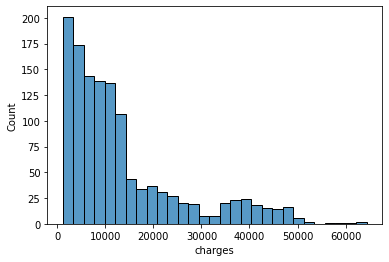

In [ ]:
sns.histplot(data.charges)
plt.show()

## Step 2: Prepare the dataset for training

We need to convert the data from the Pandas dataframe into a PyTorch tensors for training. To do this, the first step is to convert it numpy arrays. If you've filled out `input_cols`, `categorial_cols` and `output_cols` correctly, this following function will perform the conversion to numpy arrays.

In [ ]:
def dataframe_to_arrays(data):
    # Make a copy of the original dataframe
    dataframe1 = data.copy(deep=True)
    # Convert non-numeric categorical columns to numbers
    for col in categorical_cols:
        dataframe1[col] = dataframe1[col].astype('category').cat.codes
    # Extract input & outupts as numpy arrays
    inputs_array = dataframe1[input_cols].to_numpy()
    targets_array = dataframe1[output_cols].to_numpy()
    return inputs_array, targets_array

In [ ]:
inputs_array, targets_array = dataframe_to_arrays(data)
inputs_array, targets_array

(array([[43.     ,  1.     , 46.0526 ,  2.     ,  1.     ],
        [25.     ,  0.     , 28.39265,  0.     ,  0.     ],
        [37.     ,  0.     , 42.108  ,  2.     ,  1.     ],
        ...,
        [47.     ,  1.     , 30.7461 ,  1.     ,  1.     ],
        [35.     ,  1.     , 29.1973 ,  1.     ,  0.     ],
        [43.     ,  0.     , 30.5767 ,  1.     ,  1.     ]]),
 array([[42986.034704 ],
        [ 3238.5562635],
        [40234.88419  ],
        ...,
        [22198.463669 ],
        [ 5176.467857 ],
        [21989.055723 ]]))

In [ ]:
inputs = torch.from_numpy(inputs_array).float()
targets = torch.from_numpy(targets_array).float()

In [ ]:
inputs.dtype, targets.dtype

(torch.float32, torch.float32)

Next, we need to create PyTorch datasets & data loaders for training & validation. We'll start by creating a `TensorDataset`.

In [ ]:
dataset = TensorDataset(inputs, targets)
dataset

In [ ]:
val_percent = 0.15 # between 0.1 and 0.2
val_size = int(num_rows * val_percent)
train_size = num_rows - val_size


train_ds, val_ds = random_split(dataset, (train_size, val_size)) # Use the random_split function to split dataset into 2 parts of the desired length

In [ ]:
batch_size = 128

In [ ]:
train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size)

Let's look at a batch of data to verify everything is working fine so far.

In [ ]:
for xb, yb in train_loader:
    print("inputs:", xb)
    print("targets:", yb)
    break

inputs: tensor([[21.0000,  0.0000, 39.5428,  2.0000,  0.0000],
        [23.0000,  0.0000, 34.0252,  0.0000,  0.0000],
        [18.0000,  0.0000, 36.6690,  0.0000,  0.0000],
        [38.0000,  0.0000, 45.6533,  0.0000,  0.0000],
        [55.0000,  0.0000, 35.9370,  2.0000,  0.0000],
        [63.0000,  0.0000, 38.4780,  0.0000,  0.0000],
        [26.0000,  0.0000, 27.3581,  0.0000,  0.0000],
        [27.0000,  1.0000, 39.4278,  3.0000,  0.0000],
        [47.0000,  0.0000, 43.5600,  1.0000,  0.0000],
        [45.0000,  0.0000, 36.8989,  1.0000,  1.0000],
        [25.0000,  1.0000, 37.0139,  0.0000,  0.0000],
        [54.0000,  0.0000, 56.5070,  2.0000,  0.0000],
        [62.0000,  1.0000, 36.3242,  0.0000,  0.0000],
        [51.0000,  1.0000, 38.2784,  0.0000,  0.0000],
        [19.0000,  1.0000, 38.6232,  0.0000,  1.0000],
        [53.0000,  0.0000, 27.6848,  1.0000,  1.0000],
        [19.0000,  0.0000, 34.9448,  0.0000,  1.0000],
        [19.0000,  0.0000, 29.7721,  1.0000,  0.0000],
  

## Step 3: Create a Linear Regression Model

Our model itself is a fairly straightforward linear regression (we'll build more complex models in the next assignment). 


In [ ]:
input_size = len(input_cols)
output_size = len(output_cols)

In [ ]:
#loss_fn = torch.nn.functional.mse_loss(inputs, targets)
F.l1_loss = torch.nn.functional.l1_loss

In [ ]:
class InsuranceModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, output_size)                  # fill this (hint: use input_size & output_size defined above)
        
    def forward(self, xb):
        out = self.linear(xb)                          # fill this
        return out
    
    def training_step(self, batch):
        inputs, targets = batch 
        # Generate predictions
        out = self(inputs)          
        # Calcuate loss
        loss = F.l1_loss(out,targets)                          # fill this
        return loss
    
    def validation_step(self, batch):
        inputs, targets = batch
        # Generate predictions
        out = self(inputs)
        # Calculate loss
        loss =  F.l1_loss(out,targets)                          # fill this    
        return {'val_loss': loss.detach()}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        return {'val_loss': epoch_loss.item()}
    
    def epoch_end(self, epoch, result, num_epochs):
        # Print result every 20th epoch
        if (epoch+1) % 20 == 0 or epoch == num_epochs-1:
            print("Epoch [{}], val_loss: {:.4f}".format(epoch+1, result['val_loss']))

In [ ]:
model = InsuranceModel()

Let's check out the weights and biases of the model using `model.parameters`.

In [ ]:
list(model.parameters())

[Parameter containing:
 tensor([[ 0.1279, -0.1042,  0.2990, -0.3417, -0.4364]], requires_grad=True),
 Parameter containing:
 tensor([-0.3855], requires_grad=True)]

## Step 4: Train the model to fit the data

To train our model, we'll use the same `fit` function explained in the lecture. That's the benefit of defining a generic training loop - you can use it for any problem.

In [ ]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result, epochs)
        history.append(result)
    return history

In [ ]:
result = evaluate(model,val_loader)  # Use the the evaluate function
print(result)

{'val_loss': 14868.943359375}



We are now ready to train the model. You may need to run the training loop many times, for different number of epochs and with different learning rates, to get a good result. Also, if your loss becomes too large (or `nan`), you may have to re-initialize the model by running the cell `model = InsuranceModel()`. Experiment with this for a while, and try to get to as low a loss as possible.

In [ ]:
epochs = 200
lr = 1e-3
history1 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 13832.6377
Epoch [40], val_loss: 13317.4355
Epoch [60], val_loss: 12815.9688
Epoch [80], val_loss: 12345.0684
Epoch [100], val_loss: 11923.6318
Epoch [120], val_loss: 11545.8652
Epoch [140], val_loss: 11223.6016
Epoch [160], val_loss: 10936.9590
Epoch [180], val_loss: 10677.0957
Epoch [200], val_loss: 10450.8037


In [ ]:
epochs = 400
lr = 1e-5
history2 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 10448.7168
Epoch [40], val_loss: 10446.6270
Epoch [60], val_loss: 10444.5430
Epoch [80], val_loss: 10442.4531
Epoch [100], val_loss: 10440.3730
Epoch [120], val_loss: 10438.2754
Epoch [140], val_loss: 10436.1875
Epoch [160], val_loss: 10434.1035
Epoch [180], val_loss: 10432.0195
Epoch [200], val_loss: 10429.9355
Epoch [220], val_loss: 10427.8652
Epoch [240], val_loss: 10425.7832
Epoch [260], val_loss: 10423.6953
Epoch [280], val_loss: 10421.6211
Epoch [300], val_loss: 10419.5547
Epoch [320], val_loss: 10417.4775
Epoch [340], val_loss: 10415.4062
Epoch [360], val_loss: 10413.3447
Epoch [380], val_loss: 10411.2754
Epoch [400], val_loss: 10409.2061


In [ ]:
epochs = 500
lr = 1e-3
history3 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 10183.3984
Epoch [40], val_loss: 10029.0156
Epoch [60], val_loss: 9895.8945
Epoch [80], val_loss: 9783.1973
Epoch [100], val_loss: 9690.2148
Epoch [120], val_loss: 9612.1582
Epoch [140], val_loss: 9545.2090
Epoch [160], val_loss: 9491.0938
Epoch [180], val_loss: 9446.1953
Epoch [200], val_loss: 9407.0166
Epoch [220], val_loss: 9373.0703
Epoch [240], val_loss: 9344.3555
Epoch [260], val_loss: 9318.7500
Epoch [280], val_loss: 9296.7246
Epoch [300], val_loss: 9277.7090
Epoch [320], val_loss: 9262.2656
Epoch [340], val_loss: 9248.8809
Epoch [360], val_loss: 9237.6738
Epoch [380], val_loss: 9227.4609
Epoch [400], val_loss: 9217.7480
Epoch [420], val_loss: 9208.5596
Epoch [440], val_loss: 9200.3594
Epoch [460], val_loss: 9192.8066
Epoch [480], val_loss: 9185.7227
Epoch [500], val_loss: 9179.3320


In [ ]:
epochs = 50
lr = 1e-3
history4 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 9173.5723
Epoch [40], val_loss: 9167.9365
Epoch [50], val_loss: 9165.3672


In [ ]:
epochs = 1000
lr = 1e-3
history5 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 9159.9404
Epoch [40], val_loss: 9154.8145
Epoch [60], val_loss: 9149.8301
Epoch [80], val_loss: 9145.3516
Epoch [100], val_loss: 9140.9648
Epoch [120], val_loss: 9136.7871
Epoch [140], val_loss: 9132.9170
Epoch [160], val_loss: 9129.0039
Epoch [180], val_loss: 9125.3545
Epoch [200], val_loss: 9121.7578
Epoch [220], val_loss: 9118.2480
Epoch [240], val_loss: 9114.8809
Epoch [260], val_loss: 9111.4707
Epoch [280], val_loss: 9108.1172
Epoch [300], val_loss: 9104.9629
Epoch [320], val_loss: 9101.8955
Epoch [340], val_loss: 9098.6875
Epoch [360], val_loss: 9095.6699
Epoch [380], val_loss: 9092.5625
Epoch [400], val_loss: 9089.6650
Epoch [420], val_loss: 9086.7949
Epoch [440], val_loss: 9083.9102
Epoch [460], val_loss: 9080.8916
Epoch [480], val_loss: 9077.9961
Epoch [500], val_loss: 9075.2422
Epoch [520], val_loss: 9072.5400
Epoch [540], val_loss: 9069.7715
Epoch [560], val_loss: 9066.8594
Epoch [580], val_loss: 9063.9746
Epoch [600], val_loss: 9061.0811
Epoch [620], v

In [ ]:
val_loss = 9002

## Step 5: Make predictions using the trained model



In [ ]:
def predict_single(input, target, model):
    inputs = input.unsqueeze(0)
    predictions = model(inputs)                # fill this
    prediction = predictions[0].detach()
    print("Input:", input)
    print("Target:", target)
    print("Prediction:", prediction)

In [ ]:
input, target = val_ds[0]
predict_single(input, target, model)

Input: tensor([56.0000,  1.0000, 40.8073,  0.0000,  0.0000])
Target: tensor([11086.0078])
Prediction: tensor([11282.5029])


In [ ]:
input, target = val_ds[10]
predict_single(input, target, model)

Input: tensor([48.0000,  0.0000, 44.2557,  0.0000,  0.0000])
Target: tensor([8757.9033])
Prediction: tensor([10191.1543])


In [ ]:
input, target = val_ds[23]
predict_single(input, target, model)

Input: tensor([60.0000,  1.0000, 48.2790,  0.0000,  1.0000])
Target: tensor([48655.0938])
Prediction: tensor([12346.6807])
